# Experiment Design for Parameter Precision in a Fed-Batch Fermentation Model

Consider the following model of a fed-batch fermentation of baker's yeast under Monod-type kinetics, frequently used as a benchmark for experiment design methodologies [(Sandrin _et al_, 2025)](https://doi.org/10.1016/j.jprocont.2025.103465).
$$\begin{align}
    \dot{X}(t) =\ & \left[r(S(t)) - D(t) - \alpha \right] X(t) \\
    \dot{S}(t) =\ & - \frac{r(S(t))}{Y} X(t) + D(t) \left[ S_{\rm in}(t) - S(t) \right] \\
    \text{with:}\ r(S) \doteq\ & \mu \frac{S}{K+S}.
\end{align}$$
The variables $X$ (g L$^{-1}$) and $S$ (g L$^{-1}$) denote the biomass and substrate concentrations in the reactor, respectively. 

The duration of an experimental batch is set to 10 hours. The experimental setup allows measurements for $X$ and $S$ to be taken at 2-hour intervals during each batch, yielding 5 sampling times at $t=2, 4, \ldots, 10$ h. Measurements are assumed to be independently and identically distributed (IID), and to follow Gaussian distributions with standard deviation $0.2$ g L$^{-1}$ for both $X$ and $S$. The experiment controls include the dilution rate $D(t) \in [0.05, 0.2]$ h$^{-1}$ and the substrate concentration in the feed $S_{\rm in}(t) \in [5, 35]$ g L$^{-1}$. The initial biomass concentration $X(0) \in [1, 10]$ g L$^{-1}$ is also treated as an experiment design variable to be optimized alongside the experiment controls, while fixing the initial substrate concentration at $S(0)=0.1$  g L$^{-1}$.

The maximal growth rate $\mu$ (h$^{-1}$), half-saturation constant $K$ (g L$^{-1}$), product yield $Y$ ($-$), and respiration rate $\alpha$ (h$^{-1}$) are all uncertain parameters. They are assumed to be uniformly distributed with $\mu\sim\mathcal{U}(0.186, 0.434)$, $K\sim\mathcal{U}(0.108, 0.252)$, $Y\sim\mathcal{U}(0.33, 0.77)$, and $\alpha\sim\mathcal{U}(0.03, 0.07)$. In local designs, their nominal values are set to the medians $\mu=0.31$, $K=0.18$, $Y=0.55$, $\alpha=0.05$. 

We wish to design experiment campaigns that are maximally informative in the **D-optimal** sense, where the experiment controls $D$ and $S_{\rm in}$ are kept constant during a batch. Together with the initial biomass concentration $X(0)$, the corresponding experiment design problem has **three degrees of freedom**. We consider a risk-neutral design to maximize the average of information content, as well as and a risk-averse design to maximize the lower quartile of information content.

In [1]:
import numpy as np
import pymc
import cronos

We start by defining the DAG for the dynamic model:

In [2]:
IVPDAG = pymc.FFGraph()
IVPDAG.options.MAXTHREAD = 0

# States
X   = pymc.FFVar(IVPDAG, "X")   # biomass concentration [g/L]
S   = pymc.FFVar(IVPDAG, "S")   # substrate concentration [g/L]

# Initial concentrations
X0 = pymc.FFVar(IVPDAG, "X0")
S0 = pymc.FFVar(IVPDAG, "S0")

# Controls
D   = pymc.FFVar(IVPDAG, "D")   # dilution rate [/h]
Sin = pymc.FFVar(IVPDAG, "Sin") # inlet substrate concentration [g/L]

# Estimated parameters
mu = pymc.FFVar(IVPDAG, "mu")   # maximal growth rate [/h]
K  = pymc.FFVar(IVPDAG, "K")    # half-saturation constant [g/L]
Yp = pymc.FFVar(IVPDAG, "Y")    # product yield [-]
a  = pymc.FFVar(IVPDAG, "a")    # respiration rate [/h]

We instantiate `ODESLV` and populate it with the dynamic model expressions:

In [3]:
IVP = cronos.ODESLV()

IVP.set_dag( IVPDAG )
IVP.set_parameter( [D, Sin, X0] )
IVP.set_constant( [mu, K, Yp, a, S0] )
IVP.set_state( [X, S] )

r = mu * S / ( K + S )
dX  = ( r - D - a ) * X
dS  = - r / Yp * X + D * (Sin - S )

IVP.set_differential( [dX, dS] )
IVP.set_initial( [ X0, S0] )

timegrid = np.linspace( 0, 10, 6, True ).tolist()
print( timegrid )
IVP.set_time( timegrid )   # measurement times every 2 h

Y = [ X, S ]
F = []
for k in range(len(timegrid)):
  if k == 0:
    F.append( {} )   # no measurement at t=0
  else:
    F.append( { (k-1)*len(Y)+i: Y[i] for i in range(len(Y)) } )
IVP.set_function( F )
print( IVP.eqn_function )

IVP.setup()

[0.0, 2.0, 4.0, 6.0, 8.0, 10.0]
[{}, {0: X, 1: S}, {2: X, 3: S}, {4: X, 5: S}, {6: X, 7: S}, {8: X, 9: S}]


We solve the dynamic model with initial parameter guesses and record trajectories for display:

In [4]:
IVP.options.DISPLEVEL = 1 # displays numerical integration results
IVP.options.RESRECORD = 50 # record 50 points along time horizon
IVP.solve_state( [0.2, 35, 7],
                 [0.31, 0.18, 0.55, 0.05, 0.1] )

<Status.Normal: 0>

 @t = 0.000000e+00 :
  x[0] = 7.000000e+00
  x[1] = 1.000000e-01
 @t = 2.000000e+00 :
  x[0] = 7.498126e+00
  x[1] = 5.426530e+00
 @t = 4.000000e+00 :
  x[0] = 8.320013e+00
  x[1] = 7.999799e+00
 @t = 6.000000e+00 :
  x[0] = 9.261637e+00
  x[1] = 8.881376e+00
 @t = 8.000000e+00 :
  x[0] = 1.031354e+01
  x[1] = 8.557411e+00
 @t = 1.000000e+01 :
  x[0] = 1.147096e+01
  x[1] = 7.351726e+00
  f[0] = 7.498126e+00
  f[1] = 5.426530e+00
  f[2] = 8.320013e+00
  f[3] = 7.999799e+00
  f[4] = 9.261637e+00
  f[5] = 8.881376e+00
  f[6] = 1.031354e+01
  f[7] = 8.557411e+00
  f[8] = 1.147096e+01
  f[9] = 7.351726e+00
 No STEPS    380
 No EVALATIONS   RHS: 501   JAC: 0
 CPU TIME (SEC)     0.00058



In [5]:
# Gather simulation results
Pred_Exp = []
for rec in IVP.results_state:
    Pred_Exp.append( [rec.t] + rec.x )
Pred_Exp = np.array( Pred_Exp ) # convert list into numpy array
#print( Pred_Exp )

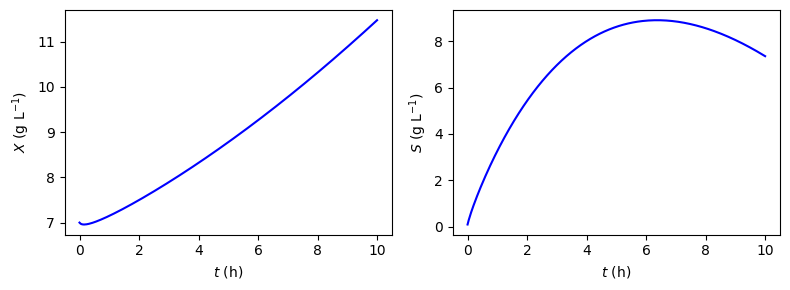

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot( Pred_Exp[:,0], Pred_Exp[:,1], color="blue" )
axes[0].set(xlabel="$t$ (h)")
axes[0].set(ylabel="$X$ (g L$^{-1}$)")

axes[1].plot( Pred_Exp[:,0], Pred_Exp[:,2], color="blue" )
axes[1].set(xlabel="$t$ (h)")
axes[1].set(ylabel="$S$ (g L$^{-1}$)")

[ fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data() ]
fig.tight_layout()

We embed the dynamic model into DAG operation:

In [7]:
OpIVP = cronos.FFODE()
IVP.options.DISPLEVEL = 0  # turn off display during numerical simulation
IVP.options.RESRECORD = 0  # turn off trajectory record
IVP.options.ATOL, IVP.options.ATOLS, IVP.options.RTOL, IVP.options.RTOLS = 1e-10, 1e-10, 1e-10, 1e-10

Ymodel = OpIVP( [D, Sin, X0], [mu, K, Yp, a, S0], IVP )
IVPDAG.output( Ymodel )


OPERATIONS IN SUBGRAPH:
  D	<<  VARIABLE
  Sin	<<  VARIABLE
  X0	<<  VARIABLE
  mu	<<  VARIABLE
  K	<<  VARIABLE
  Y	<<  VARIABLE
  a	<<  VARIABLE
  S0	<<  VARIABLE
  Z12	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[0]
  Z13	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[1]
  Z14	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[2]
  Z15	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[3]
  Z16	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[4]
  Z17	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[5]
  Z18	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[6]
  Z19	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[7]
  Z20	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[8]
  Z21	<<  ODE[0x5b69583fab30]( D, Sin, X0, mu, K, Y, a, S0 )	[9]
DEPENDENTS IN SUBGRAPH:
  0:  Z12
  1:  Z13
  2:  Z14
  3:  Z15
  4:  Z16
  5:  Z17
  6:  Z18
  7:  Z19
  8:  Z20
  9:  Z21
WORK ARRAY SIZE: 26
MOVE ARRAY SIZE: 8


In [8]:
IVPDAG.eval( Ymodel,
             [mu, K, Yp, a, D, Sin, X0, S0],
             [0.31, 0.18, 0.55, 0.05, 0.2, 35.0, 7.0, 0.1] )

[7.498125553894321,
 5.426530408779844,
 8.320013029422864,
 7.999799037703128,
 9.261636981936308,
 8.881375762138982,
 10.313543047869306,
 8.557410813184998,
 11.470957341752072,
 7.351725807453105]

We are now in a position to define the experiment design problem. We consider an initial discretization of the design domain comprising $N_{\rm c}=128$ (Sobol sampled) candidate experiments, along with $N_{\pi}=512$ (Sobol sampled) uncertainty scenarios for the model parameters.

In [9]:
from magnus import ExpDes

# Instantiate experiment design solver
ED = ExpDes()
ED.set_dag( IVPDAG )
ED.set_model( Ymodel, [0.2**2 for i in range(len(Ymodel))] );
ED.set_constant( [S0], [0.1] )

# Sampled parameters - uniform Sobol' sampling
NPSAM = 128 #1024 512
Pnom = [0.31, 0.18, 0.55, 0.05 ]
Plb  = [p*0.6 for p in Pnom]
Pub  = [p*1.4 for p in Pnom]
ED.set_parameter( [mu, Yp, K, a], ED.uniform_sample( NPSAM, Plb, Pub ) )
#print(ED.uniform_sample( NPSAM, Plb, Pub ))

# Experimental control space
NUSAM = 128;
Ulb = [0.05,  5.0,  1.0 ]
Uub = [0.2,  35.0, 10.0 ]
ED.set_control( [D, Sin, X0], Ulb, Uub )

First, we design a D-optimal campaign with $N_{\rm t} = 5$ experiments that maximizes the average of information content.

In [10]:
# Set solver options
ED.options.CRITERION = ED.DOPT
ED.options.RISK      = ED.options.NEUTRAL
ED.options.CVARTHRES = 0.25
ED.options.UNCREDUC  = 1e-3
ED.options.DISPLEVEL = 1
ED.options.MINLPSLV.DISPLEVEL = 1
ED.options.MINLPSLV.MAXITER   = 100
ED.options.MINLPSLV.NLPSLV.GRADCHECK = 0
ED.options.MINLPSLV.NLPSLV.DISPLEVEL = 0
ED.options.MINLPSLV.MIPSLV.DISPLEVEL = 0
ED.options.MINLPSLV.NLPSLV.GRADMETH  = ED.options.MINLPSLV.NLPSLV.FAD;
ED.options.NLPSLV.OPTIMTOL    = 1e-5
ED.options.NLPSLV.MAXITER     = 250
ED.options.NLPSLV.DISPLEVEL   = 1
ED.options.NLPSLV.GRADCHECK   = 0
ED.options.NLPSLV.GRADMETH    = ED.options.NLPSLV.FAD
ED.options.NLPSLV.GRADLSEARCH = 0
ED.options.NLPSLV.FCTPREC     = 1e-7

# Setup solver
ED.setup()

True

In [11]:
# Sample supports in control domain
ED.sample_support( NUSAM )

** GENERATING SUPPORT SAMPLES     |======================| 16384      3.07 SEC
** CHECKING FIM REGULARITY        | 0 SINGULAR VALUES BELOW THRESHOLD (1.00e-07)      0.00 SEC


True

In [12]:
# Run combined effort- and gradient-based experiment design
NEXP = 5
ED.combined_solve( NEXP )


#  ITERATION     INCUMBENT    BEST BOUND    TIME
        0 r*  4.363490e+01  4.377397e+01   1.30s
        1     4.363490e+01  4.377397e+01   1.41s
        2     4.363490e+01  4.377398e+01   1.46s
        3     4.363490e+01  4.377398e+01   1.52s
        4     4.363490e+01  4.377398e+01   1.58s
        5     4.363490e+01  4.377398e+01   1.63s
        6     4.363490e+01  4.377398e+01   1.69s
        7     4.363490e+01  4.377398e+01   1.75s
        8     4.363490e+01  4.377397e+01   1.80s
        9  *  4.371189e+01  4.377397e+01   1.87s
       10     4.371189e+01  4.377397e+01   1.92s
       11     4.371189e+01  4.372923e+01   1.98s
       12     4.371189e+01  4.371189e+01   2.05s

#  TERMINATION AFTER 12 ITERATIONS: 2.050 SEC
#  INCUMBENT VALUE:  4.371189e+01
#  INCUMBENT POINT: -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
#                    1.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
#                   -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
#   

In [13]:
# Evaluate optimized campaign
Copt = ED.campaign
ED.evaluate_design( Copt, "DOPT-NEUTRAL" )

** DOPT-NEUTRAL DESIGN PERFORMANCE: 4.48042e+01
   SUPPORT #0: 1.00 x [ 2.00000e-01 3.50000e+01 2.84653e+00 ]
   SUPPORT #1: 1.00 x [ 5.00000e-02 5.00000e+00 1.00000e+01 ]
   SUPPORT #2: 1.00 x [ 2.00000e-01 3.50000e+01 1.26717e+00 ]
   SUPPORT #3: 2.00 x [ 2.00000e-01 3.50000e+01 6.48231e+00 ]



(44.804240021279, [], True)

[Text(0.5, 0, '$X(0)$ (g L$^{-1}$)')]

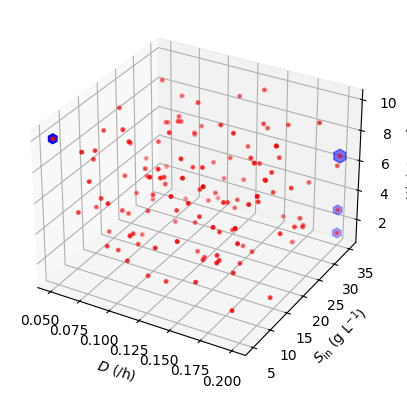

In [14]:
from mpl_toolkits import mplot3d

supp = ED.control_sample
supp = np.array( supp ) # convert list into numpy array

suppopt = []
for [e,s] in Copt:
    suppopt.append( [e] + s )
suppopt = np.array( suppopt ) # convert list into numpy array

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(supp[:,0], supp[:,1], supp[:,2], marker='.', s=10, c='r', linewidth=2);
ax.scatter(suppopt[:,1], suppopt[:,2], suppopt[:,3], s=50*suppopt[:,0], c='b', marker="h", linewidth=1);
ax.set(xlabel="$D$ (/h)")
ax.set(ylabel="$S_{\\rm in}$ (g L$^{-1}$)")
ax.set(zlabel="$X(0)$ (g L$^{-1}$)")

Next, we design a D-optimal campaign with $N_{\rm t} = 5$ experiments that maximizes the lower quartile of information content.

In [15]:
# Update solver options
ED.options.CRITERION = ED.DOPT
ED.options.RISK      = ED.options.AVERSE
ED.options.CVARTHRES = 0.25

# Setup solver
ED.setup()

True

In [16]:
# Sample supports in control domain
ED.sample_support( NUSAM )

** GENERATING SUPPORT SAMPLES     |======================| 16384      5.23 SEC
** CHECKING FIM REGULARITY        | 0 SINGULAR VALUES BELOW THRESHOLD (1.00e-07)      0.00 SEC


True

In [17]:
# Run combined effort- and gradient-based experiment design
NEXP = 5
ED.combined_solve( NEXP )


#  ITERATION     INCUMBENT    BEST BOUND    TIME
        0 r*  4.237974e+01  4.248469e+01   2.76s
        1     4.237974e+01  4.248002e+01   3.66s
        2     4.237974e+01  4.243085e+01   4.52s
        3     4.237974e+01  4.238984e+01   5.10s
        4     4.237974e+01  4.237974e+01   5.39s

#  TERMINATION AFTER 4 ITERATIONS: 5.396 SEC
#  INCUMBENT VALUE:  4.237974e+01
#  INCUMBENT POINT:  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
#                    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
#                    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
#                    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
#                    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
#                    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
#                    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
#                    0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00
#                

In [18]:
# Evaluate optimized campaign
Copt = ED.campaign
ED.evaluate_design( Copt, "DOPT-AVERSE" )

** DOPT-AVERSE DESIGN PERFORMANCE: 4.39037e+01
   SUPPORT #0: 1.00 x [ 1.89431e-01 3.50000e+01 1.00000e+01 ]
   SUPPORT #1: 1.00 x [ 5.00000e-02 5.00000e+00 1.00000e+01 ]
   SUPPORT #2: 1.00 x [ 2.00000e-01 3.50000e+01 1.00000e+00 ]
   SUPPORT #3: 1.00 x [ 2.00000e-01 3.50000e+01 6.35645e+00 ]
   SUPPORT #4: 1.00 x [ 2.00000e-01 3.50000e+01 3.22247e+00 ]



(43.90373473043524, [], True)

[Text(0.5, 0, '$X(0)$ (g L$^{-1}$)')]

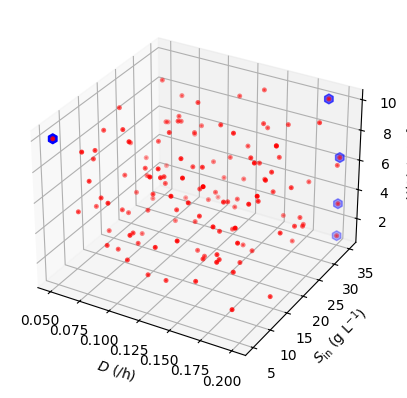

In [19]:
from mpl_toolkits import mplot3d

supp = ED.control_sample
supp = np.array( supp ) # convert list into numpy array

suppopt = []
for [e,s] in Copt:
    suppopt.append( [e] + s )
suppopt = np.array( suppopt ) # convert list into numpy array

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(supp[:,0], supp[:,1], supp[:,2], marker='.', s=10, c='r', linewidth=2);
ax.scatter(suppopt[:,1], suppopt[:,2], suppopt[:,3], s=50*suppopt[:,0], c='b', marker="h", linewidth=1);
ax.set(xlabel="$D$ (/h)")
ax.set(ylabel="$S_{\\rm in}$ (g L$^{-1}$)")
ax.set(zlabel="$X(0)$ (g L$^{-1}$)")